# **Automating Github operations using AG2**


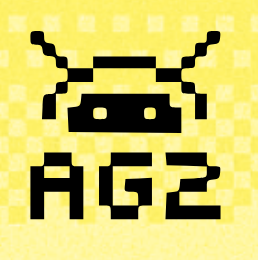

In this session we are going to discuss about Group Chat, Tools / register function and how does they interact each other.



*   **Group Chat**: An agent that provides a way to start and resume multi-agent chats.

*   **Tools**: Agents in AG2 leverage tools to extend their functionality, allowing them to interact with external systems, fetch real-time data, and execute complex tasks beyond the scope of a language model’s internal knowledge. This enables a structured approach where agents decide which tool to use and then execute it accordingly.



In [1]:
!pip install pyautogen
!pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.9 MB/s eta 0:00:00


**Sequence Diagram of GITHUB operations Agent**

---

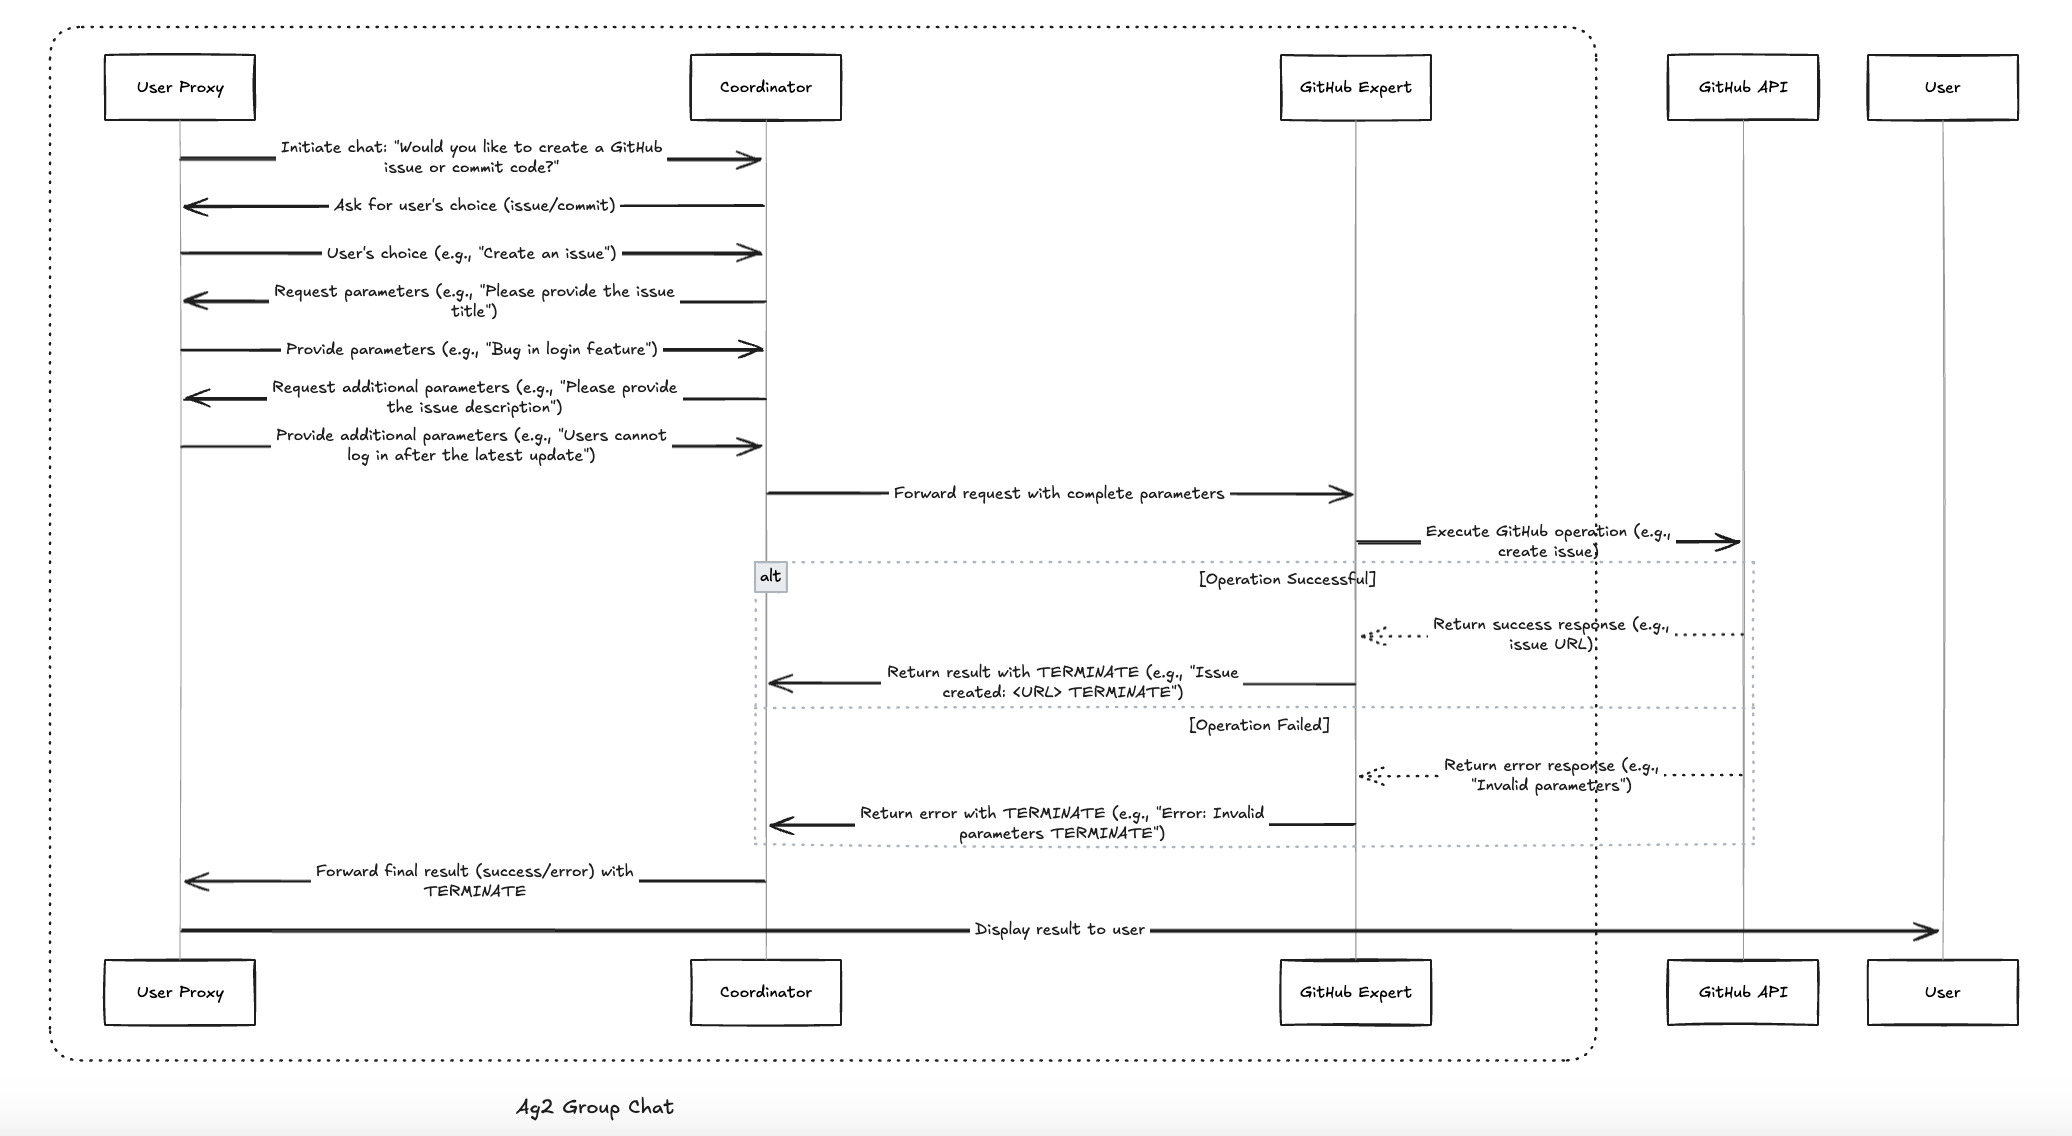

In [3]:

### imports
import requests
import base64
import re
from typing import Annotated
import autogen
from autogen import LLMConfig
from google.colab import userdata

#Defining global variables
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
GITHUB_ACCESS_TOKEN=userdata.get('GITHUB_ACCESS_TOKEN')
GITHUB_REPO_OWNER='mrmaverick9119'
GITHUB_REPO_NAME='learningwithGithub'


#creating a LLMConfig to be passed on to agents
llm_config = LLMConfig(
  api_type="openai",
  model="gpt-4o",
  api_key=OPENAI_API_KEY,
  timeout=120,              # Timeout in seconds
  temperature=0.5
)

#Defining classes for GITHUBAgents
class GitHubAgentSystem:
    def __init__(self):
        # Creating agents
        # User Proxy Agent
        self.user_proxy = autogen.UserProxyAgent(
            name="User_Proxy",
            human_input_mode="ALWAYS",
            max_consecutive_auto_reply=2,
            code_execution_config=False,
            is_termination_msg=lambda x: "TERMINATE" in x.get("content", ""),
            default_auto_reply="Please continue. Type 'exit' to end the conversation.",
        )

        # User Co-odinator Agent
        self.coordinator = autogen.AssistantAgent(
            name="Coordinator",
            system_message="""You are the workflow coordinator. Your tasks:
            1. Ask user to choose between issue creation or code commit
            2. Collect all required parameters one by one
            3. Verify parameters are complete
            4. Forward request to GitHub_Expert
            5. Return final result to user
            6. Include TERMINATE when done""",
            llm_config=llm_config,
        )

        # User GITHUB Expert Agent
        self.github_expert = autogen.AssistantAgent(
            name="GitHub_Expert",
            system_message="""You are the GitHub API expert. Your tasks:
            1. Receive complete parameters from Coordinator
            2. Execute the appropriate GitHub operation
            3. Handle API errors and validation
            4. Return results with TERMINATE""",
            llm_config=llm_config,
        )

        # Register functions and setup group chat
        self._register_functions()
        self._setup_group_chat()


    #Defining Agentic functions Funtions
    def _register_functions(self):
        # GitHub API functions
        def validate_file_path(file_path):
            if re.match(r'^[a-zA-Z0-9_\/\.\-]+$', file_path) and not file_path.startswith("/"):
                return True
            raise ValueError("Invalid file path")


        @self.user_proxy.register_for_execution()
        @self.github_expert.register_for_llm(description="Create a GitHub issue")
        def create_issue(
            title: Annotated[str, "Issue title"],
            body: Annotated[str, "Issue description"],
        ) -> str:
            try:
                url = f"https://api.github.com/repos/{GITHUB_REPO_OWNER}/{GITHUB_REPO_NAME}/issues"
                headers = {'Authorization': f'token {GITHUB_ACCESS_TOKEN}'}
                response = requests.post(url, json={'title': title, 'body': body}, headers=headers)
                if response.status_code == 201:
                    return f"Issue created: {response.json().get('html_url', '')} TERMINATE"
                return f"Error: {response.text} TERMINATE"
            except Exception as e:
                return f"Exception: {str(e)} TERMINATE"

        @self.user_proxy.register_for_execution()
        @self.github_expert.register_for_llm(description="Commit code to GitHub")
        def commit_code(
            file_path: Annotated[str, "File path in repository"],
            content: Annotated[str, "File content"],
            commit_message: Annotated[str, "Commit message"],
            branch: Annotated[str, "Branch name"] = "main"
        ) -> str:
            try:
                validate_file_path(file_path)
                url = f"https://api.github.com/repos/{GITHUB_REPO_OWNER}/{GITHUB_REPO_NAME}/contents/{file_path}"
                encoded = base64.b64encode(content.encode()).decode()
                headers = {'Authorization': f'token {GITHUB_ACCESS_TOKEN}'}
                response = requests.put(url, json={
                    'message': commit_message,
                    'content': encoded,
                    'branch': branch
                }, headers=headers)
                if response.status_code in [200, 201]:
                    return f"Commit successful: {response.json().get('content', {}).get('html_url', '')} TERMINATE"
                return f"Error: {response.text} TERMINATE"
            except Exception as e:
                return f"Exception: {str(e)} TERMINATE"

    def _setup_group_chat(self):
        # Configure group chat, Registering all three
        self.groupchat = autogen.GroupChat(
            agents=[self.user_proxy, self.coordinator, self.github_expert],
            messages=[],
            max_round=10,
            speaker_selection_method="round_robin",
        )

        self.manager = autogen.GroupChatManager(
            groupchat=self.groupchat,
            llm_config=llm_config,
            is_termination_msg=lambda x: "TERMINATE" in x.get("content", "")
        )

    def start(self):
        self.user_proxy.initiate_chat(
            self.manager,
            message="Would you like to create a GitHub issue or commit code?",
            clear_history=True
        )


# Start the execution
if __name__ == "__main__":
    system = GitHubAgentSystem()
    system.start()

User_Proxy (to chat_manager):

Would you like to create a GitHub issue or commit code?

--------------------------------------------------------------------------------

Next speaker: Coordinator

Coordinator (to chat_manager):

Please choose between the following options:
1. Create a GitHub issue
2. Commit code

Let me know which one you would like to proceed with.

--------------------------------------------------------------------------------

Next speaker: GitHub_Expert

GitHub_Expert (to chat_manager):

You can choose between the following options:

1. Create a GitHub issue
2. Commit code

Please let me know which operation you would like to proceed with.

--------------------------------------------------------------------------------

Next speaker: User_Proxy

Replying as User_Proxy. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: 

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
User_Proxy (to ch